# Darknet Object Detection using Tiny Yolov3

create folders

In [4]:
!mkdir -p ./data/images

copy images

In [5]:
!cp ../pytorch/dataset/images/field/*/* ./data/images/

Create bounding box GT file

In [32]:
!python create_boundingboxes.py

clone the darknet tool for tiny yolov3

In [1]:
!git clone https://github.com/AlexeyAB/darknet.git

Klone nach 'darknet' ...
remote: Enumerating objects: 12609, done.
remote: Total 12609 (delta 0), reused 0 (delta 0), pack-reused 12609
Empfange Objekte: 100% (12609/12609), 11.64 MiB | 7.50 MiB/s, Fertig.
Löse Unterschiede auf: 100% (8570/8570), Fertig.


Before the build set the GPU flag and the CUDNN flag in the Makefile if you have one.

In [ ]:
!make

create the leaf dataset config

In [10]:
!mkdir -p darknet/data/leaf;cp names.txt ./darknet/data/leaf/;cp leaf.data ./darknet/cfg/
!cp yolov3-tiny-leaf-*.cfg ./darknet/cfg/

create train and val file list (90% train / 10%val) randomly shuffeld in the data folder

In [6]:
import random
import glob
import os

path='./data/images/*.jpg'
names=[]
filelist = sorted(glob.glob(path))
for file in filelist:
    names.append(os.getcwd()+file[1:]+'\n')

random.shuffle(names)

trainlinesCount = int(len(names)*0.9)
vallinesCount = len(names) - trainlinesCount

print("names:{} train:{} val:{}".format(len(names),trainlinesCount,vallinesCount))

with open("./darknet/data/leaf/train.txt", "w") as f:
    f.writelines(names[:trainlinesCount])
with open("./darknet/data/leaf/valid.txt", "w") as f:
    f.writelines(names[trainlinesCount:])
    

names:7719 train:6947 val:772


### Train the tiny yolov3 darknet model

start the training (10000 steps). Add -show_imgs to see detected bounding boxes

In [ ]:
cd darknet;./darknet detector train cfg/leaf.data cfg/yolov3-tiny-leaf-train.cfg -map

start the validation

In [ ]:
cd darknet;./darknet detector valid cfg/leaf.data cfg/yolov3-tiny-leaf-test.cfg backup/yolov3-tiny-leaf-train_best.weights

### Convert the tiny yolov3 darknet model to tensor flow

clone the tensorflow converter for tiny yolov3

In [20]:
!git clone https://github.com/mystic123/tensorflow-yolo-v3

Klone nach 'tensorflow-yolo-v3' ...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 219 (delta 1), reused 2 (delta 0), pack-reused 213
Empfange Objekte: 100% (219/219), 59.90 KiB | 457.00 KiB/s, Fertig.
Löse Unterschiede auf: 100% (111/111), Fertig.


convert the darknet model to a tensorflow model

In [ ]:
!mkdir ./pbmodel;cd ./tensorflow-yolo-v3;python ./convert_weights_pb.py --class_names ../names.txt  --weights_file ../darknet/backup/yolov3-tiny-leaf-train_best.weights --tiny --output_graph  ../pbmodel/yolov3-tiny-leaf-train_best.graph --data_format NHWC

run the demo program on the tensorflow model

In [ ]:
!cd ./tensorflow-yolo-v3;python demo.py --input_img ../../norway-maple-leaf-underside.jpg --frozen_model ../pbmodel/yolov3-tiny-leaf-train_best.graph --class_names ../names.txt --gpu_memory_fraction 0.1 --output_img ./test.jpg --conf_threshold 0.1 --iou_threshold .3

Text(0.5, 1.0, 'bounding box')

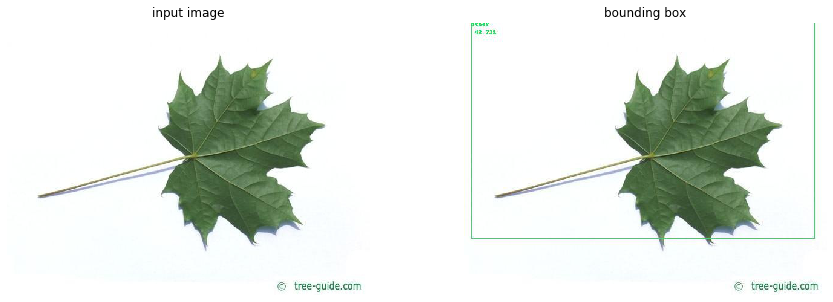

In [26]:
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

image = Image.open('../norway-maple-leaf-underside.jpg')
bb_image = Image.open('tensorflow-yolo-v3/test.jpg')


plt.figure(figsize=(15, 5))
grid_spec = gridspec.GridSpec(1, 2, width_ratios=[6, 6])

plt.subplot(grid_spec[0])
plt.imshow(image)
plt.axis('off')
plt.title('input image')

plt.subplot(grid_spec[1])
plt.imshow(bb_image)
plt.axis('off')
plt.title('bounding box')



In [18]:
### Convert the tiny yolov3 tensorflow to openvino

convert the model to IR openvino. It is copied to the DC-Box/openvion folder

In [ ]:
!./openvinoConvertScript.sh